In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils
from IPython.display import clear_output, display

In [2]:
import warnings
warnings.filterwarnings("ignore")
plt.ion()

In [3]:
denom = 2
image_width = 768//denom
image_height = 768//denom

In [4]:
train_split = 0.8

In [5]:
def rle_decode(rle_image):
    image_array = np.zeros(image_width*image_height)
    for rle_tuple in rle_image:
        number_of_pixels = int(rle_tuple[1]) - 1
        pixel = int(rle_tuple[0])
        image_array[pixel:pixel + number_of_pixels] = 1
#         for i in range(number_of_pixels):
#             pixel = int(pixel)
#             image_array[pixel + i] = 1
    return np.reshape(image_array, (image_width, image_height), order='F')

In [6]:
ships_frame = pd.read_csv('data/train_ship_segmentations_v2.csv')

n = 2
img_name = ships_frame.iloc[n, 0]
ships = ships_frame.iloc[n, 1].split(' ')
print(ships)
ships = np.asarray(ships).reshape(-1, 2)
ships = rle_decode(ships)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(ships.shape))

['264661', '17', '265429', '33', '266197', '33', '266965', '33', '267733', '33', '268501', '33', '269269', '33', '270037', '33', '270805', '33', '271573', '33', '272341', '33', '273109', '33', '273877', '33', '274645', '33', '275413', '33', '276181', '33', '276949', '33', '277716', '34', '278484', '34', '279252', '33', '280020', '33', '280788', '33', '281556', '33', '282324', '33', '283092', '33', '283860', '33', '284628', '33', '285396', '33', '286164', '33', '286932', '33', '287700', '33', '288468', '33', '289236', '33', '290004', '33', '290772', '33', '291540', '33', '292308', '33', '293076', '33', '293844', '33', '294612', '33', '295380', '33', '296148', '33', '296916', '33', '297684', '33', '298452', '33', '299220', '33', '299988', '33', '300756', '33', '301524', '33', '302292', '33', '303060', '33', '303827', '34', '304595', '34', '305363', '33', '306131', '33', '306899', '33', '307667', '33', '308435', '33', '309203', '33', '309971', '33', '310739', '33', '311507', '33', '312275

In [7]:


print(ships[:4])
print(rle_decode(ships[:4]))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


000155de5.jpg


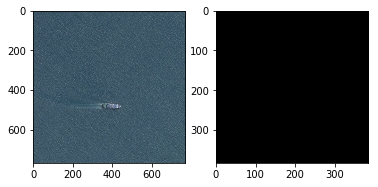

In [8]:
def show_ship_images(image, ships):
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(ships, 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
print(img_name)
show_ship_images(io.imread(os.path.join('data/train_v2', img_name)),
               ships)
plt.show()

In [9]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, loc_image = sample['image'], sample['loc_image']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = transform.resize(image, (image_height, image_width), anti_aliasing=True)
        image = image.transpose((2, 0, 1)).astype(np.float32) / 255
        #loc_image = loc_image.transpose((2, 0, 1))
        loc_image = transform.resize(loc_image, (image_height, image_width), anti_aliasing=True)
        loc_image = loc_image.reshape(1, loc_image.shape[0], loc_image.shape[1]).astype(np.float32) / 255
        contains_ship = np.asarray([1, 0], dtype=np.float32) if np.count_nonzero(loc_image) == 0 else np.asarray([0,1],dtype=np.float32)
        return {'image': torch.from_numpy(image),
                'loc_image': torch.from_numpy(loc_image),
                'contains_ship': torch.from_numpy(contains_ship)}

In [10]:
class ShipData(Dataset):
    def __init__(self):
        self.ships_dataframe = pd.read_csv('data/train_ship_segmentations_v2.csv')

    def __len__(self):
        return len(self.ships_dataframe)
    
    def __getitem__(self, idx):
        image_name = self.ships_dataframe.iloc[idx, 0]
        image_path = 'data/train_v2/' + image_name
        image = io.imread(image_path)
        if pd.isnull(self.ships_dataframe.iloc[idx, 1]):
            ship_loc_data = []
        else:
            ship_loc_data = self.ships_dataframe.iloc[idx, 1]
            ship_loc_data = ship_loc_data.split(' ')
            ship_loc_data = np.asarray(ship_loc_data).reshape(-1, 2)
        
        loc_image = rle_decode(ship_loc_data)
        
        sample = {'image': image, 'loc_image': loc_image}
        return sample
                

class MergeShipData(Dataset):
    def __init__(self):
        self.ships_dataframe = pd.read_csv('data/train_ship_segmentations_v2.csv')
        self.merge_ships_dict = self._merge_ships(self.ships_dataframe)
        self.merge_ships_dataframe = self.ships_dataframe.drop('EncodedPixels', 1).drop_duplicates()
        self.transform = transforms.Compose([ToTensor()])

    def __len__(self):
        return len(self.merge_ships_dict) - 1
    
    def _get_blank_sample(self):
        image = np.zeros((image_height, image_width, 3))
        loc_image = rle_decode([])
        return {"image": image, "loc_image": loc_image, 'contains_ship': 0}
    
    def _get_image_mask(self, idx):
        image_name = self.ships_dataframe.iloc[idx, 0]
        if pd.isnull(self.ships_dataframe.iloc[idx, 1]):
            ship_loc_data = []
        else:
            ship_loc_data = self.ships_dataframe.iloc[idx, 1]
            ship_loc_data = ship_loc_data.split(' ')
            ship_loc_data = np.asarray(ship_loc_data).reshape(-1, 2)
        
        loc_image = rle_decode(ship_loc_data)
        return loc_image
        
    def __getitem__(self, idx):
        try:
            image_name = self.merge_ships_dataframe.iloc[idx, 0]
            image_idxs = self.merge_ships_dict[image_name]
            image_path = 'data/train_v2/' + image_name
            image = io.imread(image_path)
            loc_image = self._merge_images(image_idxs)
            sample = {'image': image, 'loc_image': loc_image }
        except:
            sample = self._get_blank_sample()
        return self.transform(sample)
    
    def _merge_ships(self, df):
        ships = {}
        for idx, row in df.iterrows():
            image_name = row[0]
            if image_name in ships:
                ships[image_name].append(idx)
            else:
                ships[image_name] = [idx]
        return ships
    
    def _merge_images(self, idxs):
        img = rle_decode([])
        for idx in idxs:
            img = np.logical_or(img, self._get_image_mask(idx)).astype(float)

        return img.astype(np.uint8) * 255
            
        

In [11]:
sd = MergeShipData()

In [12]:
len(sd)

192555

In [13]:
# last = 0
# for i in range(len(sd)):
#     last = i
#     print(i)
#     sd[i]
#     clear_output(wait=True)

In [14]:
sd[1]

{'image': tensor([[[0.0017, 0.0018, 0.0019,  ..., 0.0017, 0.0017, 0.0016],
          [0.0018, 0.0019, 0.0019,  ..., 0.0017, 0.0018, 0.0017],
          [0.0019, 0.0019, 0.0019,  ..., 0.0017, 0.0018, 0.0017],
          ...,
          [0.0018, 0.0019, 0.0019,  ..., 0.0020, 0.0020, 0.0019],
          [0.0017, 0.0019, 0.0019,  ..., 0.0020, 0.0020, 0.0019],
          [0.0017, 0.0018, 0.0018,  ..., 0.0019, 0.0019, 0.0018]],
 
         [[0.0019, 0.0020, 0.0021,  ..., 0.0019, 0.0019, 0.0018],
          [0.0020, 0.0022, 0.0022,  ..., 0.0020, 0.0021, 0.0019],
          [0.0021, 0.0022, 0.0021,  ..., 0.0020, 0.0021, 0.0019],
          ...,
          [0.0020, 0.0021, 0.0021,  ..., 0.0022, 0.0022, 0.0021],
          [0.0020, 0.0021, 0.0021,  ..., 0.0022, 0.0022, 0.0021],
          [0.0019, 0.0020, 0.0020,  ..., 0.0021, 0.0021, 0.0020]],
 
         [[0.0020, 0.0021, 0.0022,  ..., 0.0020, 0.0020, 0.0019],
          [0.0021, 0.0022, 0.0022,  ..., 0.0021, 0.0021, 0.0020],
          [0.0022, 0.0022, 0.00

In [15]:
def plot_sample(sample):
    toPilImage = transforms.ToPILImage()
    to1ChannelPilImage = transforms.ToPILImage()
    image = toPilImage(sample['image'])
    loc_image = to1ChannelPilImage(sample['loc_image'])
    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(loc_image, 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [16]:
number_to = 0
number_from = 3
for i in range(number_from, number_to):
    plot_sample(sd[i])

In [17]:
def generate_train_and_test_idxs(dataset_length, train_split):
    np.random.seed(42)
    idxs = list(range(dataset_length))
    split = int(np.floor(train_split * dataset_length))
    np.random.shuffle(idxs)
    return idxs[:split], idxs[split:]

def get_train_and_test_datasets(dataset, max_length=None, batch_size=8):
    dataset_length = max_length or len(dataset)
    train_indices, val_indices = generate_train_and_test_idxs(dataset_length, train_split)
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=validation_sampler)
    return train_loader, validation_loader
    

In [18]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [19]:
def create_categorization_model():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 16, 3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2, stride=2),
        torch.nn.Conv2d(16, 20 , 3),
        torch.nn.Dropout2d(),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2, stride=2),
#         torch.nn.Conv2d(64, 128, 3, padding=1),
#         torch.nn.ReLU(),
#         torch.nn.MaxPool2d(2, stride=2),
#         torch.nn.Conv2d(128, 256, 3, padding=1),
#         torch.nn.ReLU(),
#         torch.nn.MaxPool2d(2, stride=2),
#         torch.nn.Conv2d(256, 128, 3, padding=1),
#         torch.nn.ReLU(),
#         torch.nn.MaxPool2d(2, stride=2),
#         torch.nn.Conv2d(128, 256, 3, padding=1),
#         torch.nn.ReLU(),
#         torch.nn.MaxPool2d(2, stride=2),
        Flatten(),
        torch.nn.Linear((94*94*20), 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, 2),
        torch.nn.Softmax()
    )
    return model

In [20]:
def create_model():
    model = torch.nn.Sequential(
        #torch.nn.Dropout2d(p=0.4),
        torch.nn.Conv2d(3, 16, 3, padding=1),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(16),
        torch.nn.Conv2d(16, 18, 5, padding=2),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(32),
        torch.nn.Conv2d(18, 20, 7, padding=3),
        torch.nn.Dropout2d(),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(64),
#         torch.nn.MaxPool2d(2, stride=2),
#         torch.nn.Conv2d(4, 8, 7),
#         torch.nn.ReLU(),
#         torch.nn.MaxPool2d(2, stride=2),
#         torch.nn.Conv2d(8, 16, 14),
#         torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(64),
        #torch.nn.AdaptiveMaxPool2d((image_height, image_width)),
        #torch.nn.MaxUnpool2d(64, 2),
        torch.nn.Conv2d(64, 1, 1),
        torch.nn.Sigmoid()
    )
    return model

In [49]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [50]:
model = create_categorization_model()

In [51]:
model = model.to(device)

In [52]:
optimizer = torch.optim.SGD(model.parameters(), 0.0001, momentum=0.01)
criterion = torch.nn.BCELoss()

In [53]:
loss_history = list()

In [61]:
train_loader, validation_loader = get_train_and_test_datasets(sd, max_length=1000, batch_size=4)

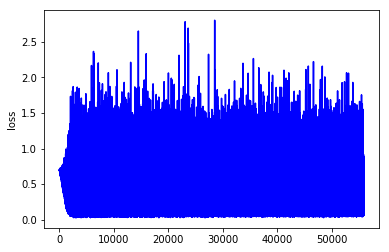

KeyboardInterrupt: 

In [62]:
num_epochs = 1000
model.train()
for epoch in range(num_epochs):
    # Train:   
    for batch_index, sample in enumerate(train_loader):
        
        image = sample['image'].to(device)
        labels = sample['contains_ship'].to(device)
        outputs = model(image)
        loss = criterion(outputs, labels)
        print(f'loss: {loss.item()}\nbatch: {batch_index}\nepoch: {epoch}')
        loss_history.append(loss.item())
        plt.plot(loss_history, color='blue')
        plt.ylabel('loss')
        #plt.show()
        #plt.plot(loss_history[len(loss_history) - 24:])
        #plt.ylabel('loss in last 24 batches')
        clear_output(wait=True)
        plt.show()
        
        
        #display(plt.gcf())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [66]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for index, sample in enumerate(validation_loader):
        image = sample['image'].to(device)
        labels = sample['contains_ship'].to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu().data.numpy().astype(np.float32) == labels[:,0]).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 15.0 %


In [ ]:
toPilImage = transforms.ToPILImage()
device = torch.device('cpu')
model = model.to(device)
model.eval()
image = sd[50]['image'].to(device)
output = model(torch.unsqueeze(image, 0))[0]

In [ ]:
toPilImage((output * (255/(output.max()))))

In [ ]:
toPilImage(image)

In [ ]:
def infer_and_compare_result(model, sample):
    model.eval()
    image = sample['image'].to(device)
    label = sample['loc_image'].to(device)
    output = model(torch.unsqueeze(image, 0))[0]
    
    
    toPilImage = transforms.ToPILImage()
    image = toPilImage(sample['image'])
    loc_image = toPilImage(sample['loc_image'])
    output_image = toPilImage(output * (255/output.max()))
    plt.figure(num=None, figsize=(32, 12), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(loc_image, 'gray')
    plt.subplot(1,3,3)
    plt.imshow(output_image, 'gray')
    
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
print(sd[15]['image'].max())
infer_and_compare_result(model, sd[33])

In [ ]:
plt.plot(loss_history)
plt.ylabel('loss')
plt.show()